In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import seaborn as sns
import itertools
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import time  


# Dataset Loading

In [54]:
import pandas as pd
import os

data_labels_path = './dataLabels.csv'
sampled_labels_path = './sampled_dataset_labels.csv'

# Read label data
data_labels = pd.read_csv(data_labels_path)  # CSV file path
total_samples = 2000  # Total number of samples to select

# Check column names in the dataframe and standardize the 'label' column name
data_labels.columns = data_labels.columns.str.strip()  # Remove spaces from column names
if 'label' not in data_labels.columns:
    print("The 'label' column is missing. Available columns:", data_labels.columns)
    raise KeyError("Please ensure the data contains a 'label' column.")

# Count the number of samples per class
class_counts = data_labels['label'].value_counts()
num_classes = len(class_counts)

# Calculate the number of samples to select per class to achieve class balance
samples_per_class = total_samples // num_classes

# Stratified random sampling
sampled_data = pd.DataFrame()  # Used to store sampling results
for class_name, count in class_counts.items():
    # Get all samples of the class
    class_data = data_labels[data_labels['label'] == class_name]
    
    # Determine the number of samples to select for the class (if the class count is insufficient, select all samples)
    n_samples = min(samples_per_class, len(class_data))
    
    # Randomly sample from the class
    sampled_class_data = class_data.sample(n=n_samples, random_state=42)
    
    # Add sampling results to sampled_data
    sampled_data = pd.concat([sampled_data, sampled_class_data])

# If the total number of sampled samples is less than 2000, supplement with remaining samples
remaining_samples_needed = total_samples - len(sampled_data)
if remaining_samples_needed > 0:
    remaining_data = data_labels[~data_labels.index.isin(sampled_data.index)]
    additional_samples = remaining_data.sample(n=remaining_samples_needed, random_state=42)
    sampled_data = pd.concat([sampled_data, additional_samples])

# Shuffle the sampled data
sampled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check sampling results
print("Sampled class distribution:\n", sampled_data['label'].value_counts())
print("Total samples:", len(sampled_data))

# Save the sampled label file
sampled_data.to_csv(sampled_labels_path, index=False)


Sampled class distribution:
 label
airplane      200
truck         200
ship          200
bird          200
dog           200
frog          200
horse         200
deer          200
automobile    200
cat           200
Name: count, dtype: int64
Total samples: 2000


In [55]:
# Read label data
labels_path = './sampled_dataset_labels.csv'
img_dir = './data/train'
labels_df = pd.read_csv(labels_path)

# Get all unique labels and create label mapping
all_labels = set([label for sublist in labels_df['label'].apply(lambda x: x.split(',')) for label in sublist])
label_map = {label: idx for idx, label in enumerate(all_labels)}
num_classes = len(label_map)


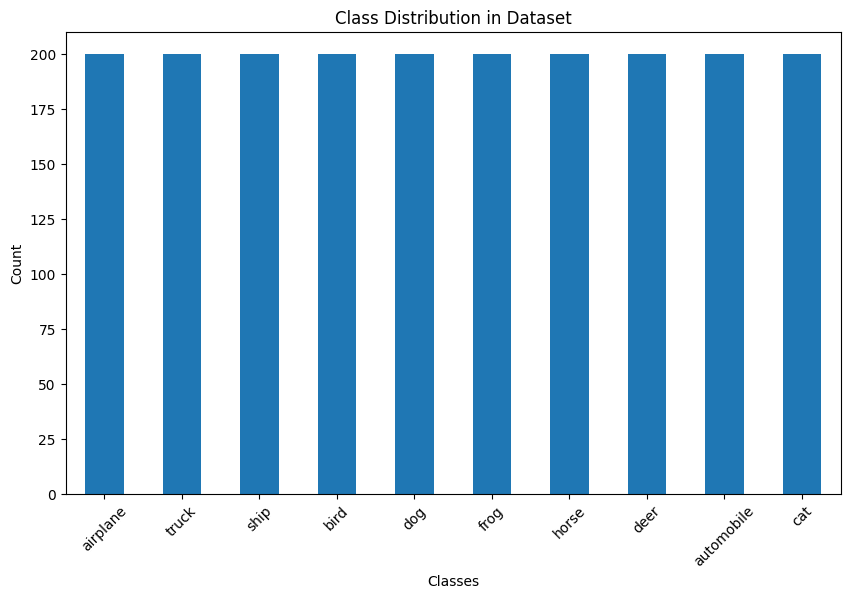

In [56]:
# Split labels and count class distribution
all_labels_1 = labels_df['label'].apply(lambda x: x.split(',')).explode().value_counts()

# Plot histogram of class distribution
plt.figure(figsize=(10, 6))
all_labels_1.plot(kind='bar')
plt.title("Class Distribution in Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Data preprocess

In [57]:
# Define multi-label dataset class
class MultiLabelDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        
        # Get multi-labels
        labels = self.labels_df.iloc[idx, 1].split(',')
        label_tensor = torch.zeros(num_classes)
        
        for label in labels:
            label_index = label_map[label]
            label_tensor[label_index] = 1

        if self.transform:
            image = self.transform(image)

        return image, label_tensor


In [58]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # Increase probability of horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),  
    # Increase rotation angle             
    transforms.RandomRotation(degrees=10),  
    # Increase crop scale range              
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)), 
    # Enhance color jitter
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.15),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [59]:
# Dataset split
train_df = labels_df.sample(frac=0.7, random_state=42)
remaining_df = labels_df.drop(train_df.index)
valid_df = remaining_df.sample(frac=0.5, random_state=42)
test_df = remaining_df.drop(valid_df.index)

# Create data loaders
train_dataset = MultiLabelDataset(train_df, img_dir, transform=transform_train)
valid_dataset = MultiLabelDataset(valid_df, img_dir, transform=transform_test)
test_dataset = MultiLabelDataset(test_df, img_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Training Models

In [60]:
# Define hyperparameters for grid search
param_grid = {
   'learning_rate': [0.001, 0.0001],
   'optimizer': ['Adam', 'SGD'],
   'scheduler': [None, 'ReduceLROnPlateau']
}
param_combinations = list(itertools.product(param_grid['learning_rate'], param_grid['optimizer'], param_grid['scheduler']))

# Define models to test
model_choices = {
    'ResNet-18': models.resnet18,
    'ResNet-34': models.resnet34,
    'MobileNetV2': models.mobilenet_v2
}


In [61]:
# Training and validation function
def train_and_evaluate(model, train_loader, valid_loader, optimizer, scheduler=None, num_epochs=20):
    criterion = nn.BCEWithLogitsLoss()
    train_loss, val_loss = [], []
    epoch_times = []  # Store the time for each epoch

    for epoch in range(num_epochs):
        # Start time record
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_loss.append(val_epoch_loss)

        if scheduler:
            scheduler.step(val_epoch_loss)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

    return train_loss, val_loss, epoch_times


In [62]:
# Store the best model and results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_models = {}


In [63]:
# Perform grid search and model comparison
for model_name, model_fn in model_choices.items():
    best_loss = float('inf')
    best_params = None
    best_model = None
    best_epoch_times = None
    total_model_time = 0

    for lr, optim_name, scheduler_name in param_combinations:

        # Check if we should train from scratch or use pre-trained weights
        if model_name == 'ResNet-18':
            model = model_fn(pretrained=False)
        else:
            model = model_fn(pretrained=True)

        # Modify the final layer to match the number of classes and set layers to be trainable or frozen as needed
        if model_name.startswith('ResNet'):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            if model_name == 'ResNet-34':
                # Freeze all layers except the final layer
                for name, param in model.named_parameters():
                    if name.startswith("fc"):
                        param.requires_grad = True
                    else:
                        param.requires_grad = False
        elif model_name == 'MobileNetV2':
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            for name, param in model.named_parameters():
                if "classifier.1" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        model.to(device)

        trainable_params = list(filter(lambda p: p.requires_grad, model.parameters()))
        
        if len(trainable_params) == 0:
            print("Error: No parameters are set to require gradients!")
            continue 

        # Initialize the optimizer with only the parameters that require gradients
        if optim_name == 'Adam':
            optimizer = optim.Adam(trainable_params, lr=lr)
        elif optim_name == 'SGD':
            optimizer = optim.SGD(trainable_params, lr=lr, momentum=0.9)

        # Define scheduler
        if scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        else:
            scheduler = None

        # Train and validate model, recording training time for each parameter combination
        start_combination_time = time.time()
        train_loss, val_loss, epoch_times = train_and_evaluate(
            model, train_loader, valid_loader, optimizer, scheduler, num_epochs=20
        )

        combination_time = time.time() - start_combination_time 
        # Accumulate into total time for the model
        total_model_time += combination_time 

        # Check best model
        if min(val_loss) < best_loss:
            best_loss = min(val_loss)
            best_params = (lr, optim_name, scheduler_name)
            best_model = model
            best_epoch_times = epoch_times

    # Save the best results for each model, including time for each epoch and total training time for all parameter combinations
    best_models[model_name] = {
        "model": best_model,
        "val_loss": best_loss,
        "params": best_params,
        "train_loss": train_loss,
        "val_loss_curve": val_loss,
        "epoch_times": best_epoch_times,
        "total_model_time": total_model_time  # Total training time for the model
    }

# Print total training time for all parameter combinations for each model
for model_name, model_info in best_models.items():
    avg_epoch_time = sum(model_info["epoch_times"]) / len(model_info["epoch_times"])
    print(f"{model_name} - Total training time for all parameters: {model_info['total_model_time']:.2f} seconds, Average epoch time: {avg_epoch_time:.2f} seconds")


c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.wa

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.
ResNet-18 - Total training time for all parameters: 1594.35 seconds, Average epoch time: 10.00 seconds
ResNet-34 - Total training time for all parameters: 1422.12 seconds, Average epoch time: 8.87 seconds
MobileNetV2 - Total training time for all parameters: 1415.38 seconds, Average epoch time: 8.86 seconds


# Test models and show the results.

In [64]:
# Define evaluation function
def test_model(model, data_loader, label_map, model_name, dataset_type="Test"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Print classification report
    print(f"\nClassification Report for {dataset_type} Set ({model_name}):")
    print(classification_report(all_labels, all_preds, target_names=label_map.keys()))
    
    # Calculate overall metrics
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro')
    overall_accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Multi-class overall confusion matrix
    cm = confusion_matrix(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Overall Confusion Matrix ({dataset_type} Set, {model_name})')
    plt.show()



Best Model: ResNet-18
Hyperparameters: (0.001, 'Adam', 'ReduceLROnPlateau')


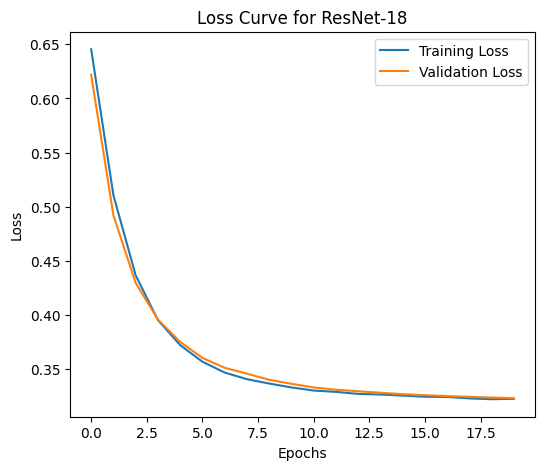


Classification Report for Test Set (ResNet-18):
              precision    recall  f1-score   support

  automobile       0.68      0.78      0.72        27
         dog       0.62      0.26      0.36        39
       horse       0.67      0.29      0.41        34
    airplane       0.46      0.26      0.33        23
        bird       0.46      0.46      0.46        39
        frog       0.81      0.54      0.65        24
         cat       0.50      0.12      0.19        26
       truck       0.85      0.49      0.62        35
        deer       1.00      0.08      0.14        26
        ship       0.81      0.63      0.71        27

   micro avg       0.65      0.39      0.49       300
   macro avg       0.69      0.39      0.46       300
weighted avg       0.68      0.39      0.46       300
 samples avg       0.38      0.39      0.39       300

Overall Precision: 0.6864
Overall Recall: 0.3900
Overall F1 Score: 0.4598
Overall Accuracy: 0.3767


c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

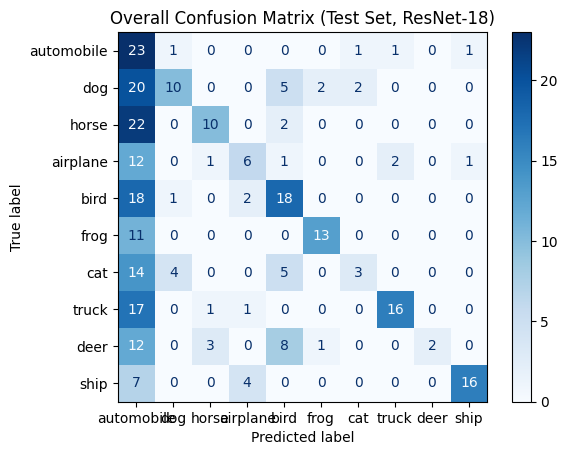


Best Model: ResNet-34
Hyperparameters: (0.001, 'Adam', 'ReduceLROnPlateau')


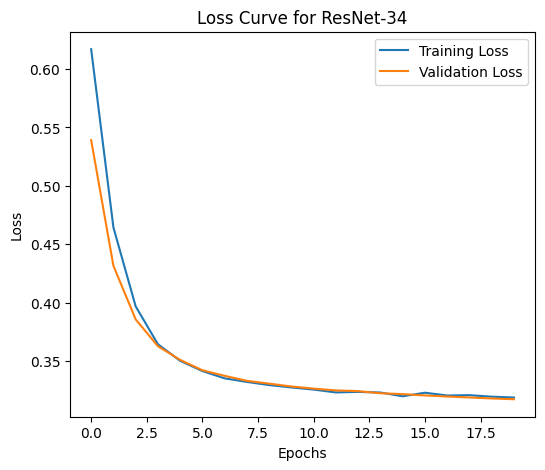


Classification Report for Test Set (ResNet-34):
              precision    recall  f1-score   support

  automobile       0.84      0.78      0.81        27
         dog       0.90      0.69      0.78        39
       horse       0.77      0.79      0.78        34
    airplane       0.74      0.61      0.67        23
        bird       1.00      0.26      0.41        39
        frog       0.89      0.67      0.76        24
         cat       0.83      0.19      0.31        26
       truck       0.95      0.60      0.74        35
        deer       0.80      0.31      0.44        26
        ship       0.92      0.81      0.86        27

   micro avg       0.86      0.57      0.69       300
   macro avg       0.86      0.57      0.66       300
weighted avg       0.87      0.57      0.66       300
 samples avg       0.55      0.57      0.56       300

Overall Precision: 0.8642
Overall Recall: 0.5711
Overall F1 Score: 0.6566
Overall Accuracy: 0.5367


c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

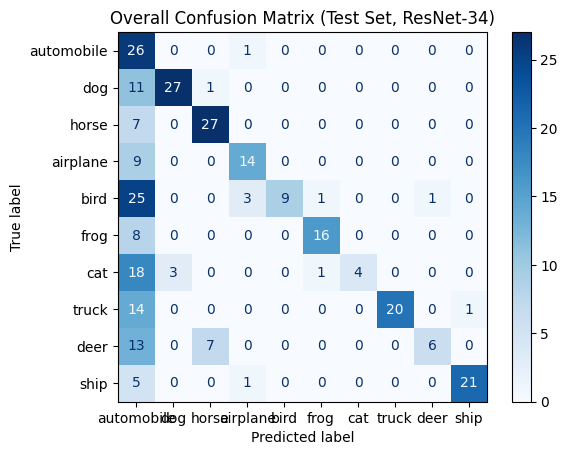


Best Model: MobileNetV2
Hyperparameters: (0.001, 'Adam', 'ReduceLROnPlateau')


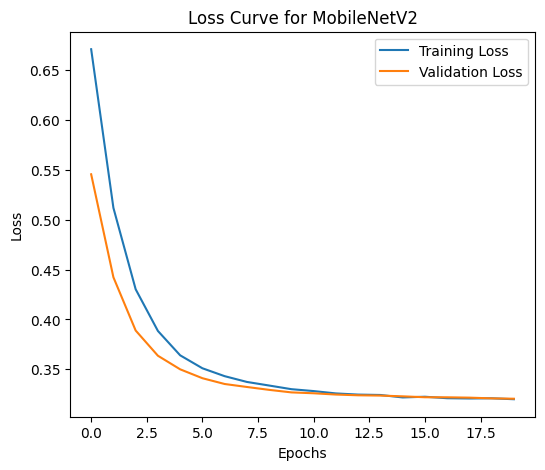


Classification Report for Test Set (MobileNetV2):
              precision    recall  f1-score   support

  automobile       0.93      0.52      0.67        27
         dog       0.78      0.18      0.29        39
       horse       0.81      0.62      0.70        34
    airplane       0.93      0.57      0.70        23
        bird       1.00      0.18      0.30        39
        frog       0.76      0.54      0.63        24
         cat       0.80      0.31      0.44        26
       truck       1.00      0.20      0.33        35
        deer       0.71      0.19      0.30        26
        ship       1.00      0.30      0.46        27

   micro avg       0.86      0.34      0.49       300
   macro avg       0.87      0.36      0.48       300
weighted avg       0.88      0.34      0.47       300
 samples avg       0.34      0.34      0.34       300

Overall Precision: 0.8726
Overall Recall: 0.3598
Overall F1 Score: 0.4837
Overall Accuracy: 0.3333


c:\Users\Aufb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

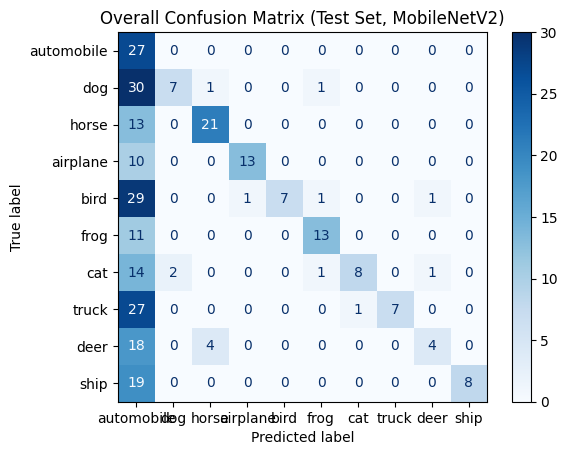

In [65]:
# Evaluate each best model on the test set
for model_name, model_info in best_models.items():
    print(f"\nBest Model: {model_name}")
    print("Hyperparameters:", model_info["params"])

    # Visualize loss curve
    plt.figure(figsize=(6, 5))
    plt.plot(model_info["train_loss"], label='Training Loss')
    plt.plot(model_info["val_loss_curve"], label='Validation Loss')
    plt.title(f'Loss Curve for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Perform final evaluation using the test set, passing model name for display in confusion matrix
    test_model(model_info["model"], test_loader, label_map, model_name, dataset_type="Test")
